### Rede Neural - MLP (Multi-layer Perceptron)

In [1]:
# Importando os módulos necessários para o processamento dos dados
import numpy   as np
import pandas  as pd

# Módulos necessários para visualização dos dados
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Importando os módulos auxiliares

from sklearn.model_selection import train_test_split # Divisão de conjunto de treinamento e teste
from sklearn.model_selection import cross_validate # Validação cruzada do modelo
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV # Busca pelos melhores hiperparâmetros
from sklearn.externals import joblib # Necessário para salvar os modelos treinados em arquivos externos
from imblearn.over_sampling import SMOTE # Balanceamento de classes

# Métricas de avaliação

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
import itertools

# Função auxiliar para plotar a matriz de confusão. 
# Retirada de: 
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

def plot_confusion_matrix(cm, 
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Classe real')
    plt.xlabel('Classe predita')
    
def gerar_dataset_balanceado(train_data, 
                             train_target, 
                             test_data, 
                             test_target):
    
    sm = SMOTE(random_state=0)
    
    train_data_b, train_target_b = sm.fit_sample(pd.get_dummies(train_data), train_target)

    train_data_b = pd.DataFrame(train_data_b, columns=pd.get_dummies(train_data).columns)
    train_data_b['earnings'] = train_target_b
    train_data_b = train_data_b.sample(frac=1) # Embaralha os registros
    
    train_target_b = train_data_b['earnings']
    train_data_b.drop(columns='earnings', inplace=True)
    
    
    test_data_b, test_target_b = sm.fit_sample(pd.get_dummies(test_data), test_target)

    test_data_b = pd.DataFrame(test_data_b, columns=pd.get_dummies(test_data).columns)
    test_data_b['earnings'] = test_target_b
    test_data_b = test_data_b.sample(frac=1) # Embaralha os registros
    
    test_target_b = test_data_b['earnings']
    test_data_b.drop(columns='earnings', inplace=True)
    
    return train_data_b, train_target_b, test_data_b, test_target_b

# ATENÇÃO!!! Escolher corretamente qual a fração do dataset que está sendo utilizada

fracao_dataset = 0.1

In [2]:
# Importando os arquivos com os datasets pré-processados

path_arquivos = 'Data/'

data_pre_proc_1 = pd.read_csv(path_arquivos+'data-pre-proc-1.csv')
data_pre_proc_2 = pd.read_csv(path_arquivos+'data-pre-proc-2.csv')
data_pre_proc_3 = pd.read_csv(path_arquivos+'data-pre-proc-3.csv')
data_pre_proc_4 = pd.read_csv(path_arquivos+'data-pre-proc-4.csv')

# Descartando a primeira coluna, que é só identificador do registro

data_pre_proc_1 = data_pre_proc_1.iloc[:,1::]
data_pre_proc_2 = data_pre_proc_2.iloc[:,1::]
data_pre_proc_3 = data_pre_proc_3.iloc[:,1::]
data_pre_proc_4 = data_pre_proc_4.iloc[:,1::]

# Separando o target e dividindo os conjuntos de treino e teste para cada dataset

# Dataset 1

target_1 = data_pre_proc_1['earnings']
data_pre_proc_1.drop(columns='earnings', inplace=True)

train_data_1, test_data_1, train_target_1, test_target_1 = train_test_split(
    data_pre_proc_1, target_1, test_size=0.33, random_state=0)

train_data_b_1, train_target_b_1, test_data_b_1, test_target_b_1 = gerar_dataset_balanceado(
    train_data_1, train_target_1, test_data_1, test_target_1)

# Dataset 2

target_2 = data_pre_proc_2['earnings']
data_pre_proc_2.drop(columns='earnings', inplace=True)

train_data_2, test_data_2, train_target_2, test_target_2 = train_test_split(
    data_pre_proc_2, target_2, test_size=0.33, random_state=0)

train_data_b_2, train_target_b_2, test_data_b_2, test_target_b_2 = gerar_dataset_balanceado(
    train_data_2, train_target_2, test_data_2, test_target_2)
    
# Dataset 3
    
target_3 = data_pre_proc_3['earnings']
data_pre_proc_3.drop(columns='earnings', inplace=True)

train_data_3, test_data_3, train_target_3, test_target_3 = train_test_split(
    data_pre_proc_3, target_3, test_size=0.33, random_state=0)

train_data_b_3, train_target_b_3, test_data_b_3, test_target_b_3 = gerar_dataset_balanceado(
    train_data_3, train_target_3, test_data_3, test_target_3)
    
# Dataset 4    

target_4 = data_pre_proc_4['earnings']
data_pre_proc_4.drop(columns='earnings', inplace=True)

train_data_4, test_data_4, train_target_4, test_target_4 = train_test_split(
    data_pre_proc_4, target_4, test_size=0.33, random_state=0)

train_data_b_4, train_target_b_4, test_data_b_4, test_target_b_4 = gerar_dataset_balanceado(
    train_data_4, train_target_4, test_data_4, test_target_4)

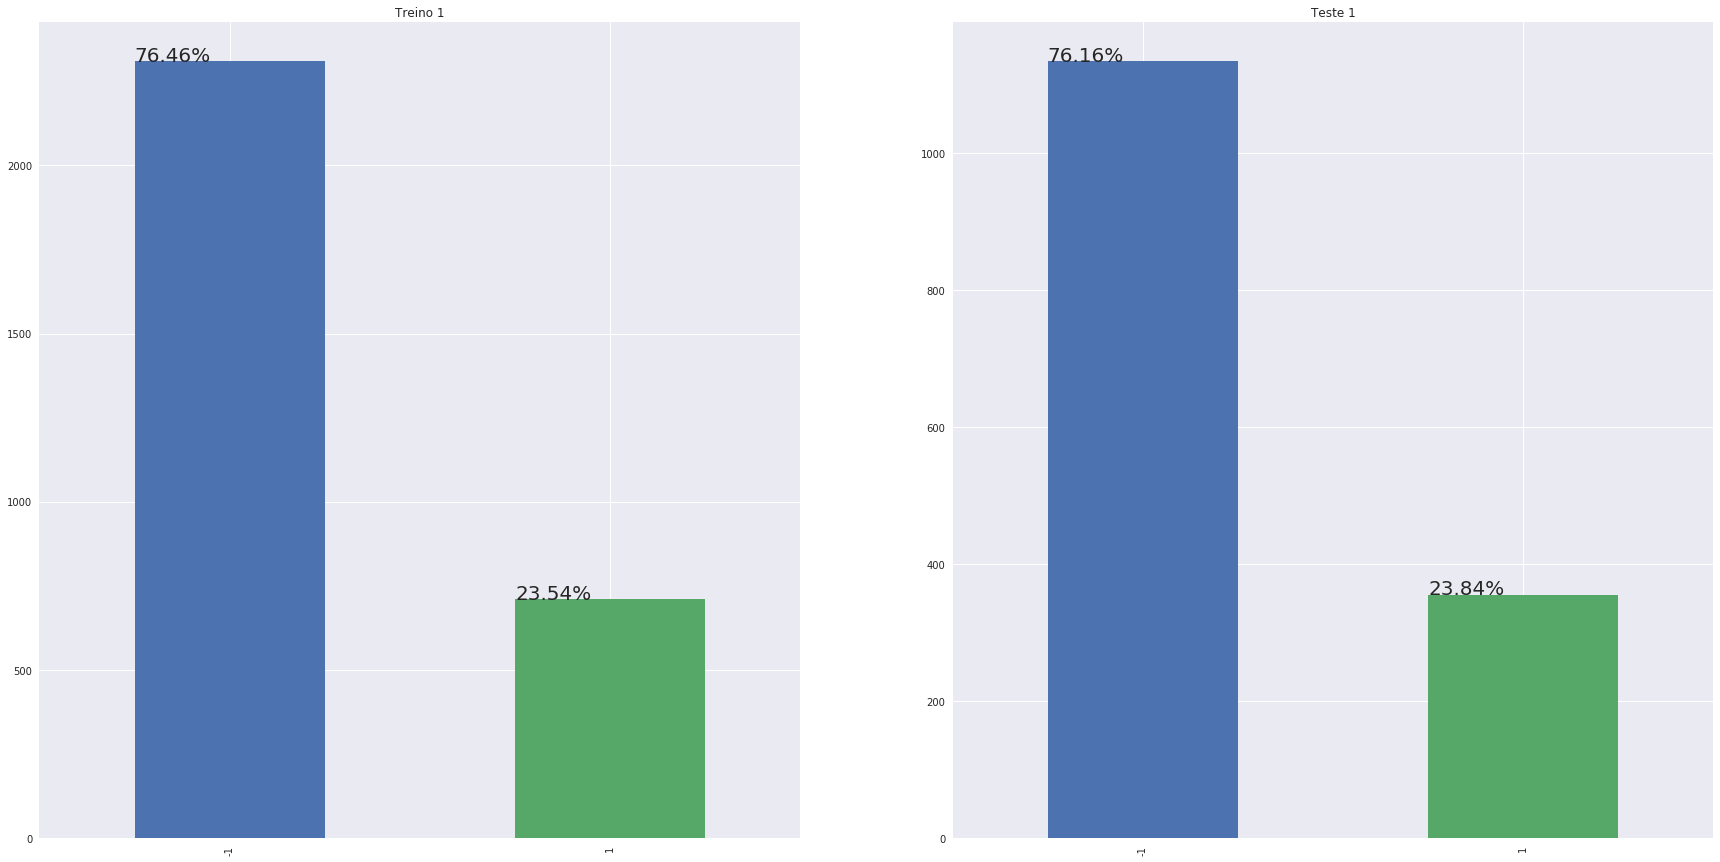

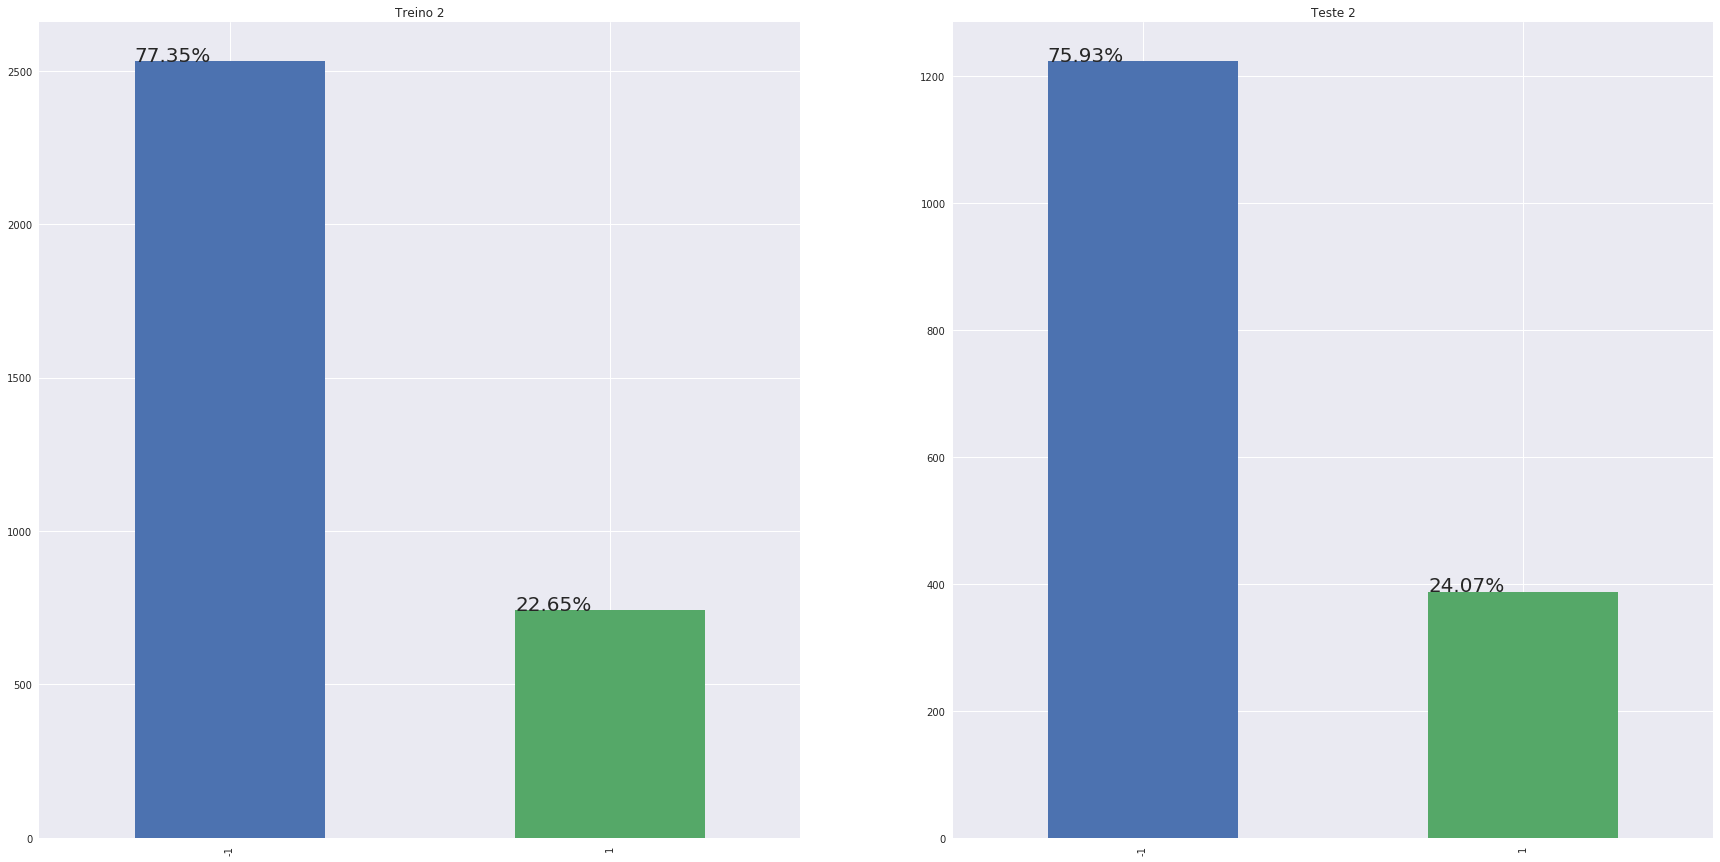

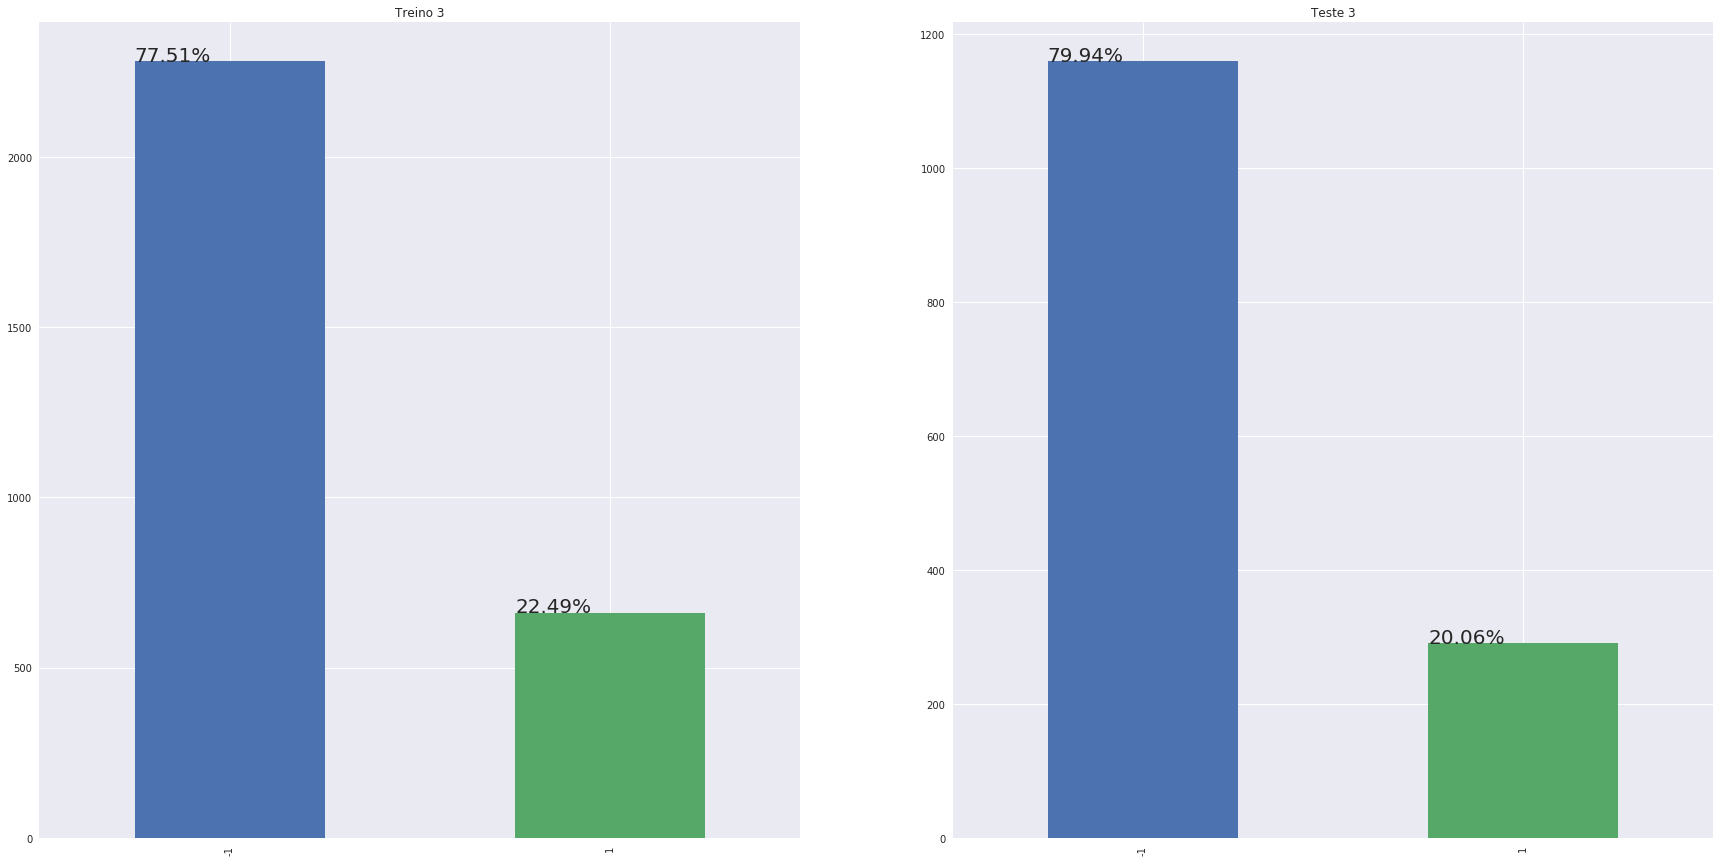

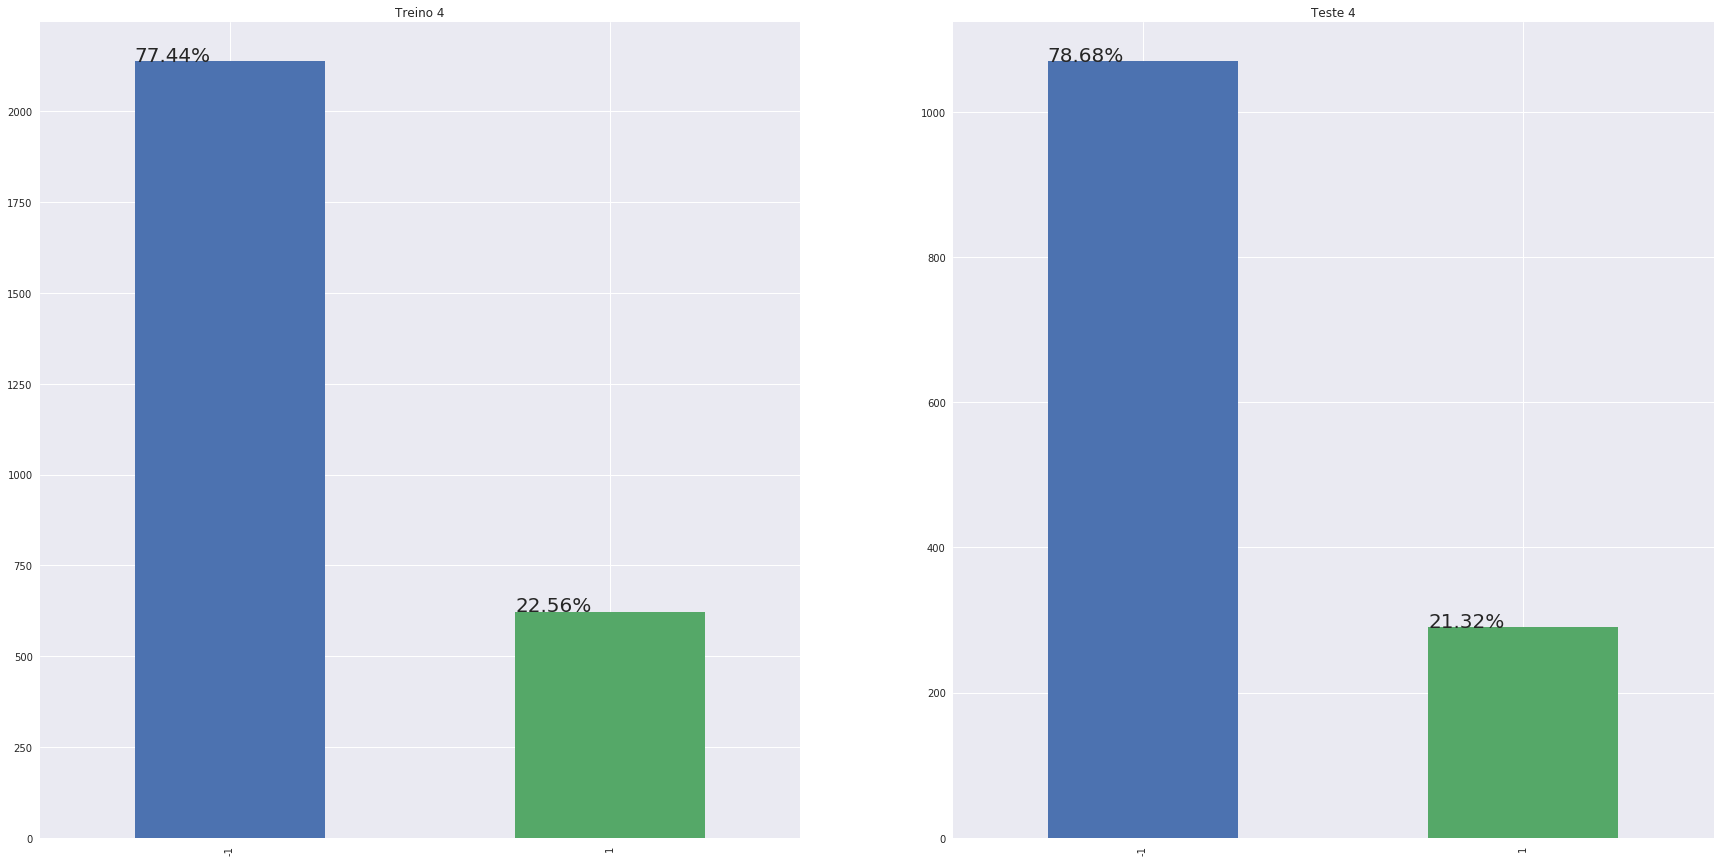

In [3]:
# Checando a distribuição dos targets em cada conjunto (treino e teste) de cada abordagem

sns.set(style='darkgrid')
temp_train = [train_target_1, train_target_2, train_target_3, train_target_4]
temp_test = [test_target_1, test_target_2, test_target_3, test_target_4]

for i in range(4):
    
    fig = plt.figure(figsize=(30,15))

    plt.subplot(121)
    ax = temp_train[i].value_counts().plot.bar()
    for patch in ax.patches:
#         ax.text(patch.get_x(), patch.get_height(), str(int(patch.get_height())),fontsize=20)
        ax.text(patch.get_x(), patch.get_height(), "{:.2f}%".format((int(patch.get_height())/temp_train[i].shape[0]*100)),fontsize=20)
    plt.title('Treino ' + str(i+1))
#     plt.show()

#     fig = plt.figure(figsize=(30,15))
    
    plt.subplot(122)
    ax = temp_test[i].value_counts().plot.bar()
    for patch in ax.patches:
#         ax.text(patch.get_x(), patch.get_height(), str(int(patch.get_height())),fontsize=20)
        ax.text(patch.get_x(), patch.get_height(), "{:.2f}%".format((int(patch.get_height())/temp_test[i].shape[0]*100)),fontsize=20)
    plt.title('Teste ' + str(i+1))
#     plt.show()

In [4]:
# Importando módulos da rede neural

from sklearn.neural_network import MLPClassifier 

# Definindo os parâmetros do modelo e possíveis valores

# param_grid_one = {'hidden_layer_sizes': list(zip(map(int,np.logspace(start=1,stop=7,num=7,base=2)))), 
#                   'alpha': list(np.logspace(start=-4,stop=1,num=6,base=10))}

param_grid_one = {'hidden_layer_sizes': list(zip(map(int,np.logspace(start=4,stop=4,num=1,base=2)))), 
                  'alpha': list(np.logspace(start=-4,stop=-4,num=1,base=10))}

# print(param_grid_one)

param_grid_two = {'hidden_layer_sizes': [ (a,b) for a in list(map(int,np.logspace(start=1,stop=7,num=7,base=2))) for b in list(map(int,np.logspace(start=1,stop=7,num=7,base=2))) ],
                  'alpha': list(np.logspace(start=-4,stop=1,num=6,base=10))}

# print(param_grid_two)

mlp = MLPClassifier(activation='tanh',batch_size=16, max_iter=1)

# Validação cruzada com cada conjunto de parâmetros

clf_one = GridSearchCV(mlp,param_grid_one,return_train_score=True,cv=10,
                   scoring = ['accuracy', 'precision', 'recall', 'roc_auc', 'f1', 'average_precision'], refit=False)
              
clf_two = GridSearchCV(mlp,param_grid_two,return_train_score=True,cv=10,
                   scoring = ['accuracy', 'precision', 'recall', 'roc_auc', 'f1', 'average_precision'], refit=False)

#### Treinamento

In [18]:
# Descomentar somente se for necessário retreinar o classificador

# Abordagem 1: Retirar os valores faltantes e manter outliers

path_arquivos = 'Classificadores/Redes-neurais-MLP/' # Path para salvar os resultados dos classificadores

clf_one.fit(pd.get_dummies(train_data_1), train_target_1) # Classes desbalanceadas
joblib.dump(clf_one, 
            path_arquivos+'mlp-one-abordagem-1-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada

# clf_one.fit(train_data_b_1, train_target_b_1) # Classes balanceadas
# joblib.dump(clf_one, 
#             path_arquivos+'mlp-one-abordagem-1-balanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada

# clf_two.fit(pd.get_dummies(train_data_1), train_target_1)
# joblib.dump(clf_two, 
#             path_arquivos+'mlp-one-abordagem-1-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada

# clf_two.fit(train_data_b_1, train_target_b_1)
# joblib.dump(clf_two, 
#             path_arquivos+'mlp-one-abordagem-1-balanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada



['Classificadores/Redes-neurais-MLP/mlp-one-abordagem-1-desbalanceado-dataset-10pct.pkl']

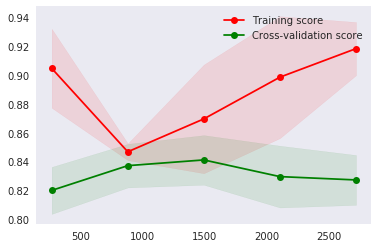

In [22]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
        mlp, pd.get_dummies(train_data_1), train_target_1, cv=10, train_sizes=np.linspace(.1, 1.0, 5))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

plt.legend(loc="best")

0
1


/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999


ValueError: x and y must have same first dimension, but have shapes (1,) and (2000,)

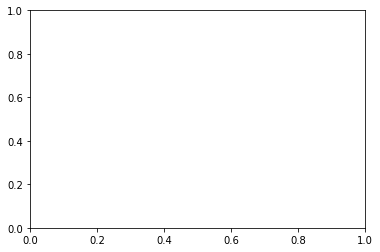

In [5]:
max_epochs = 2000

epoch = 0

scores_training = []
scores_test = []

while epoch < max_epochs:
    
    print(epoch)
    mlp.fit(pd.get_dummies(train_data_1), train_target_1)
    scores_training.append(mlp.score(pd.get_dummies(train_data_1), train_target_1))
    scores_test.append(mlp.score(pd.get_dummies(test_data_1), test_target_1))
#     results = pd.DataFrame(clf_one.cv_results_)
#     results_test = results.loc[:, 'split0_test_accuracy':'split9_train_roc_auc']
#     results_train = results_test.filter(regex=(".*train.*"))
#     results_test.drop(columns=results_train.columns,inplace=True)
#     results_test_filtered = results_test.filter(regex='.*_test_accuracy').transpose()
#     results_train_filtered = results_train.filter(regex='.*_train_accuracy').transpose()
#     scores_training.append(results_train_filtered.mean())
#     scores_test.append(results_test_filtered.mean())
    epoch += 1
    
plt.plot(np.arange(1,max_epochs+1), scores_training, label='Treino', color='blue', lw=2)
plt.plot(np.arange(1,max_epochs+1), scores_test, label='Validação', color='green', lw=2)
plt.legend(loc='best')

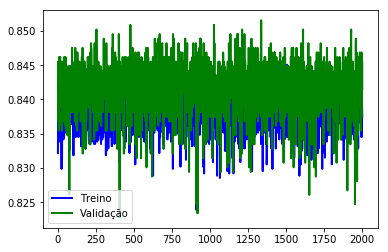

In [20]:
plt.plot(np.arange(1,max_epochs+1), scores_training, label='Treino', color='blue', lw=2)
plt.plot(np.arange(1,max_epochs+1), scores_test, label='Validação', color='green', lw=2)
plt.legend(loc='best')
plt.show()

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


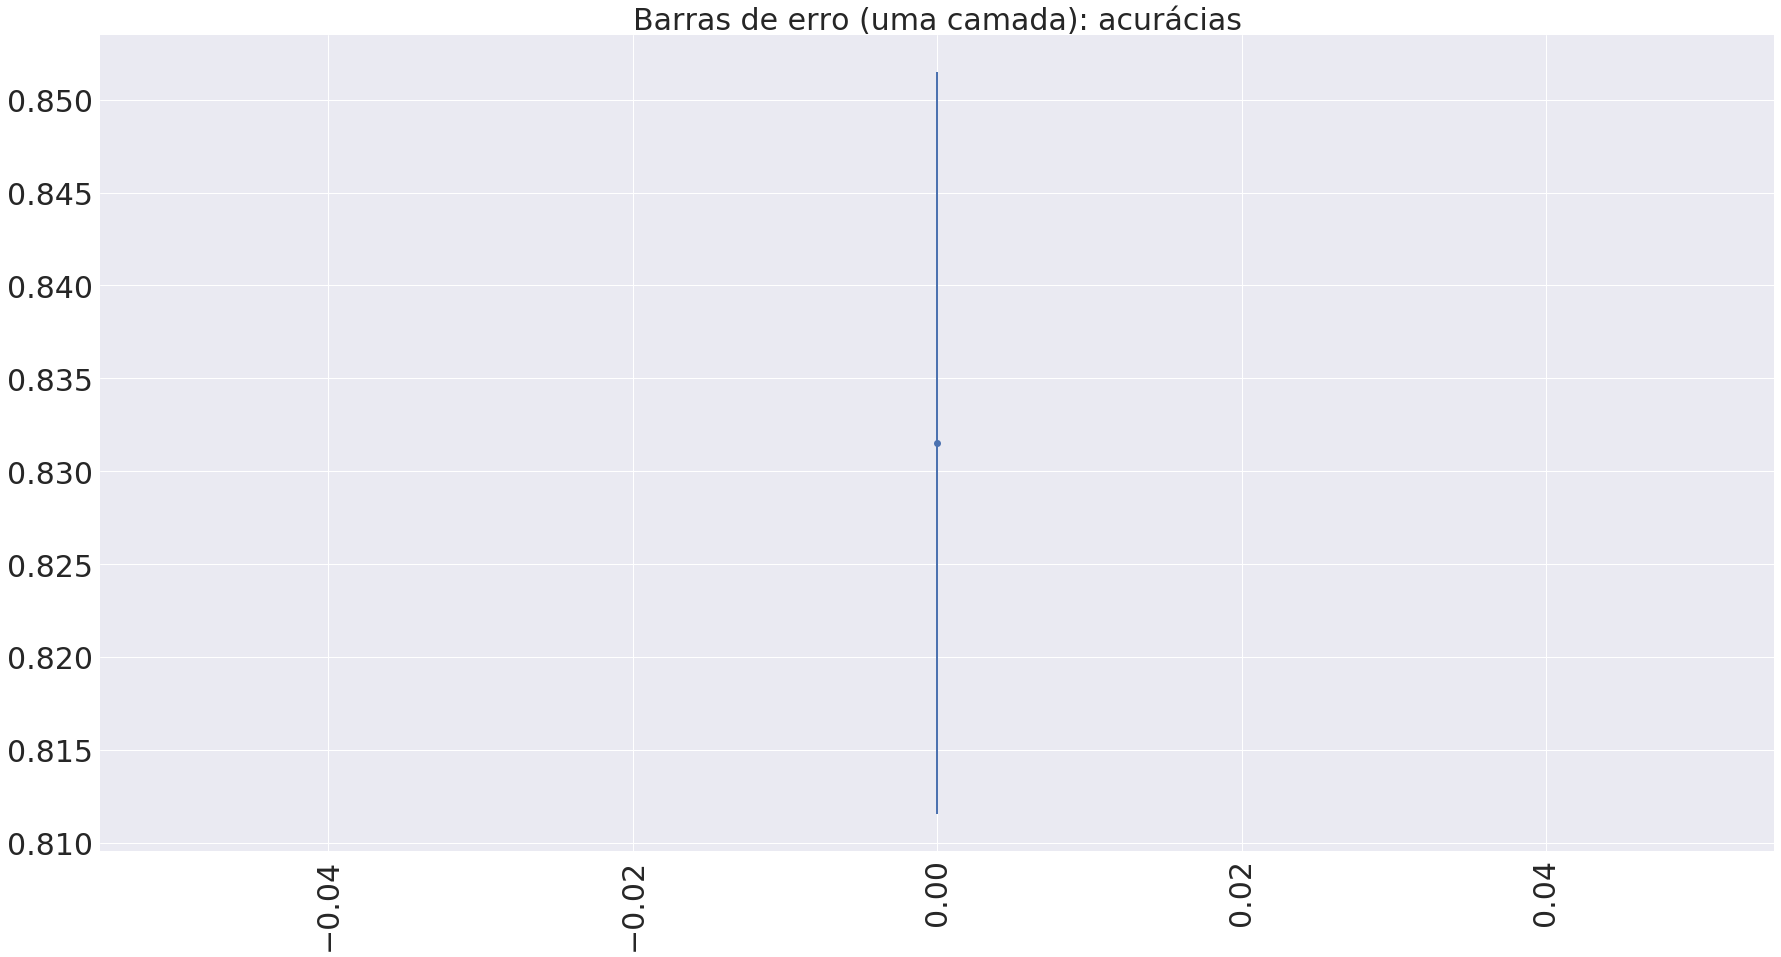

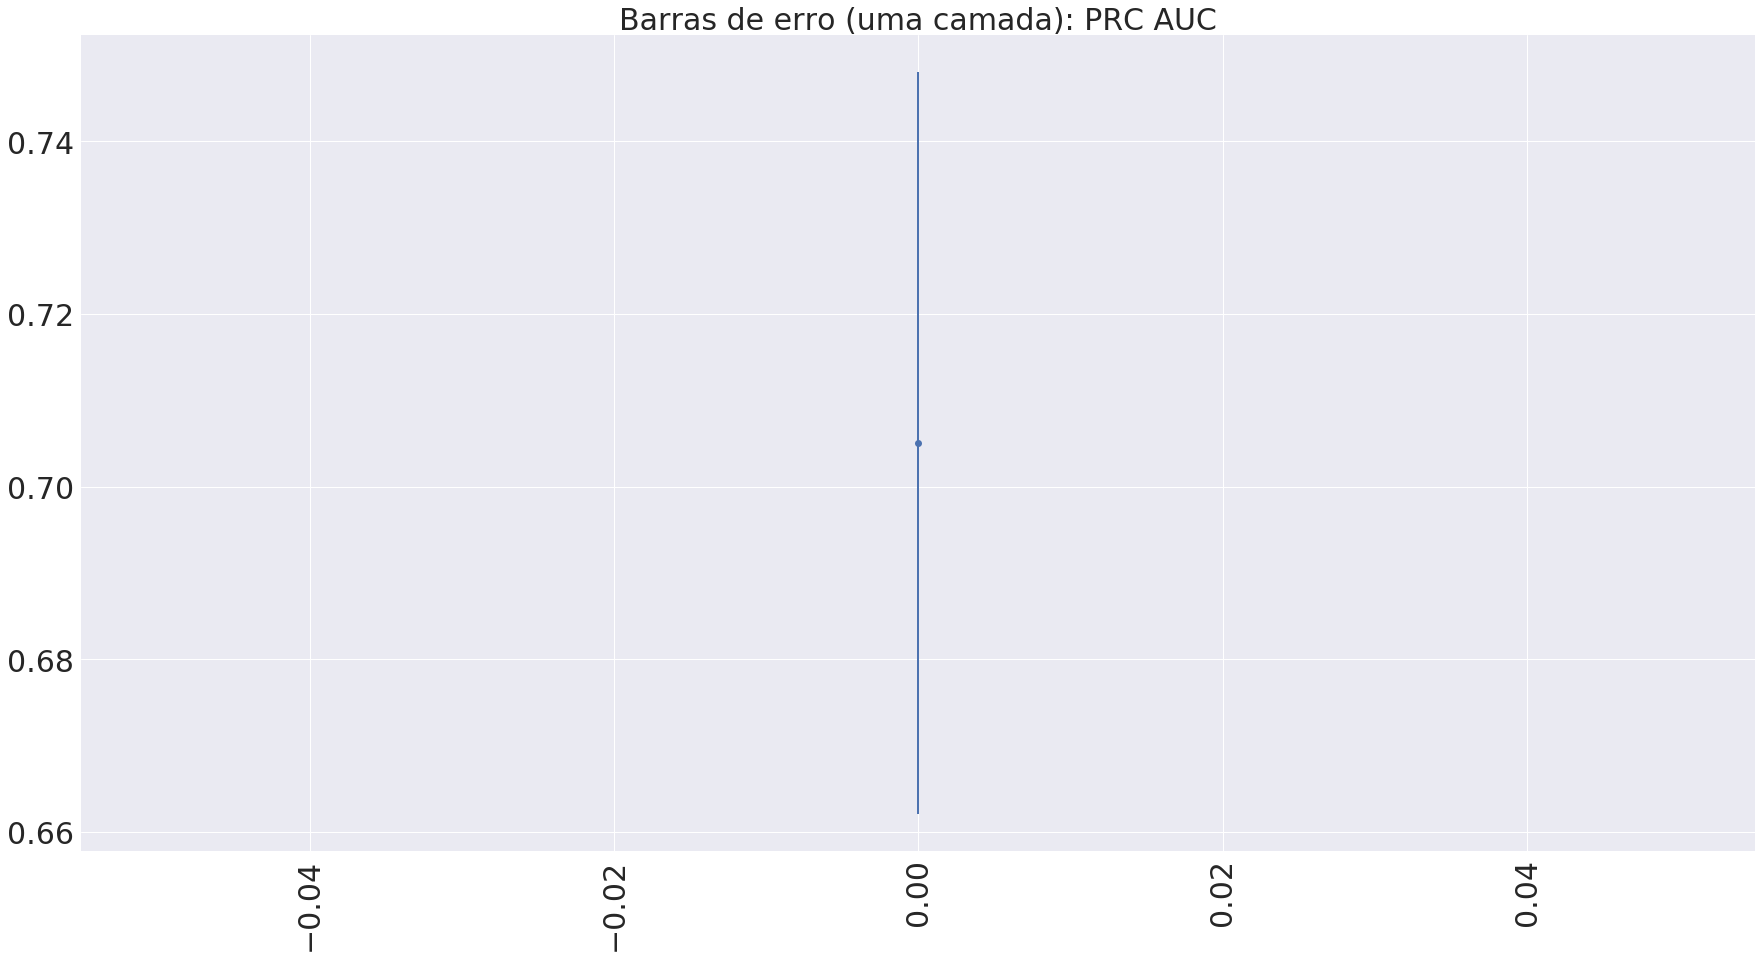

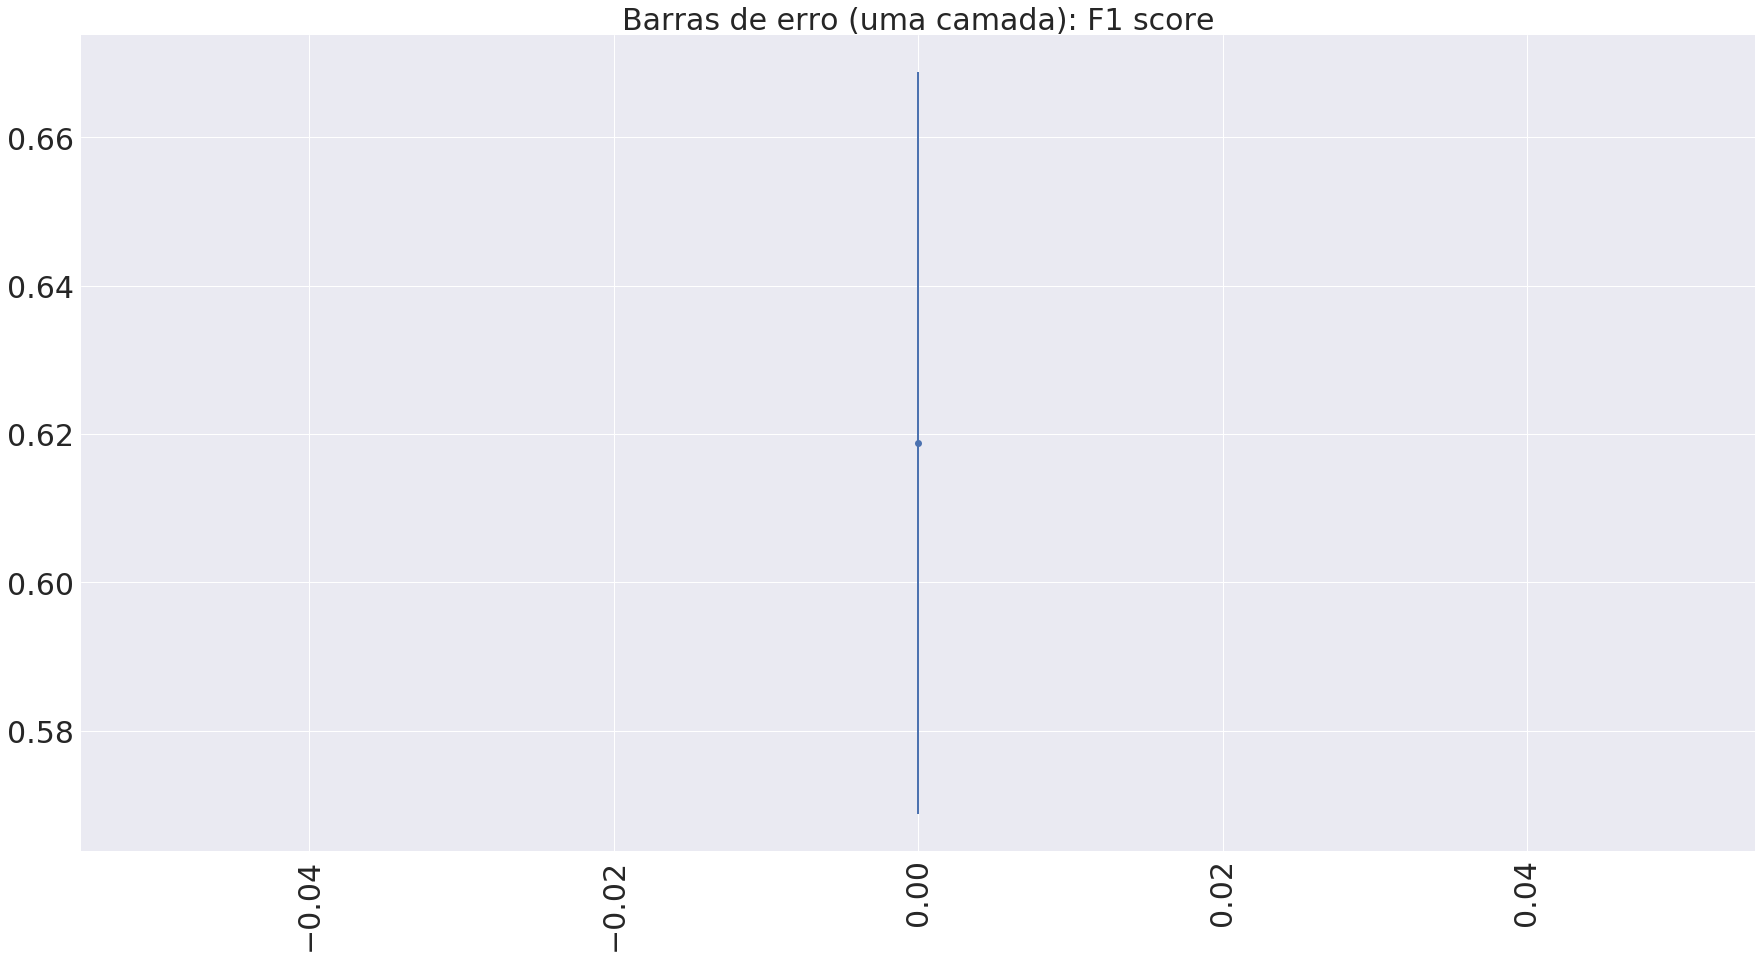

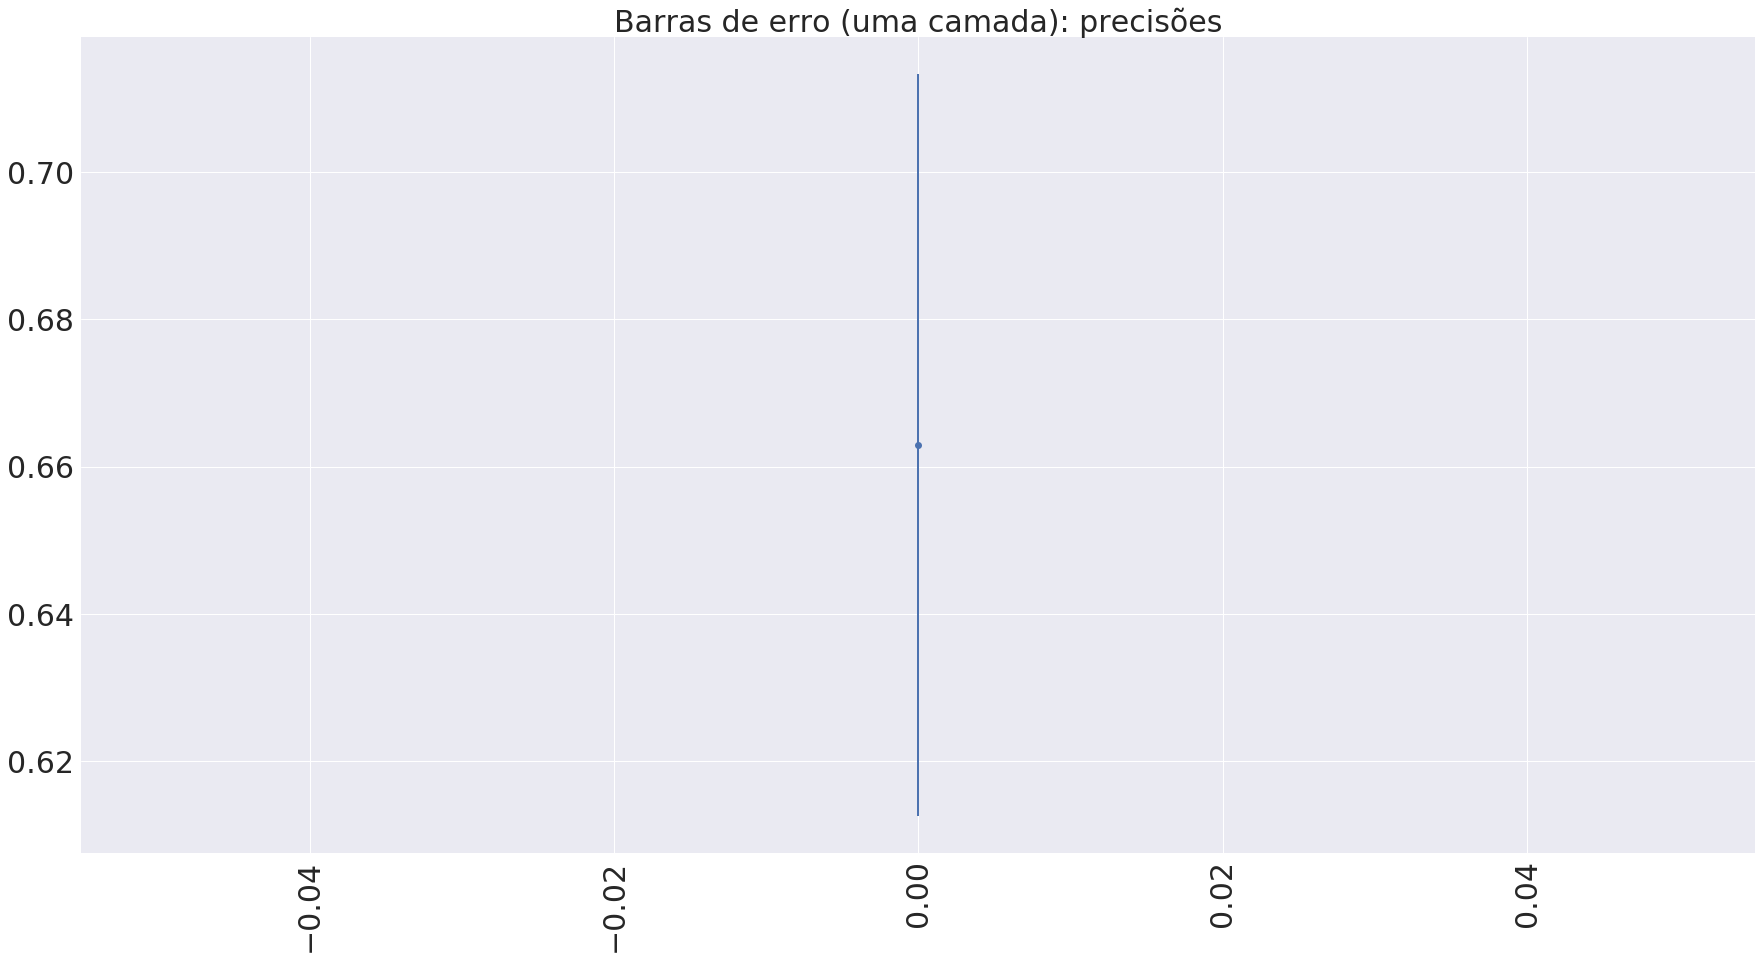

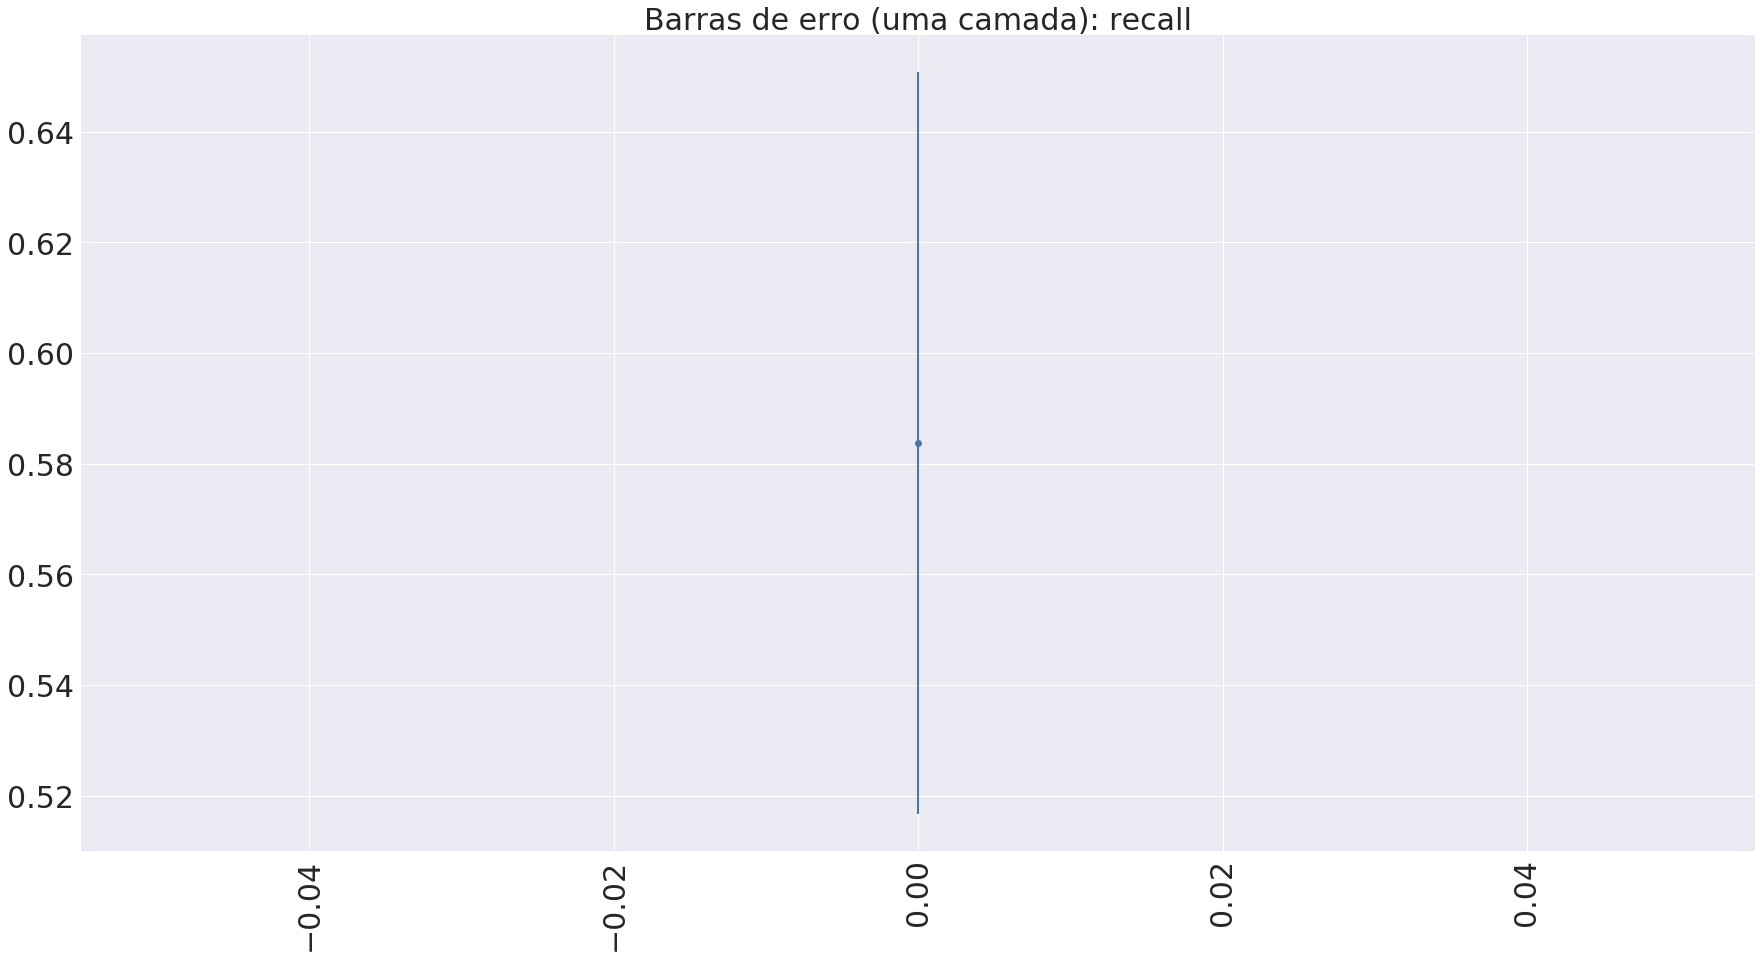

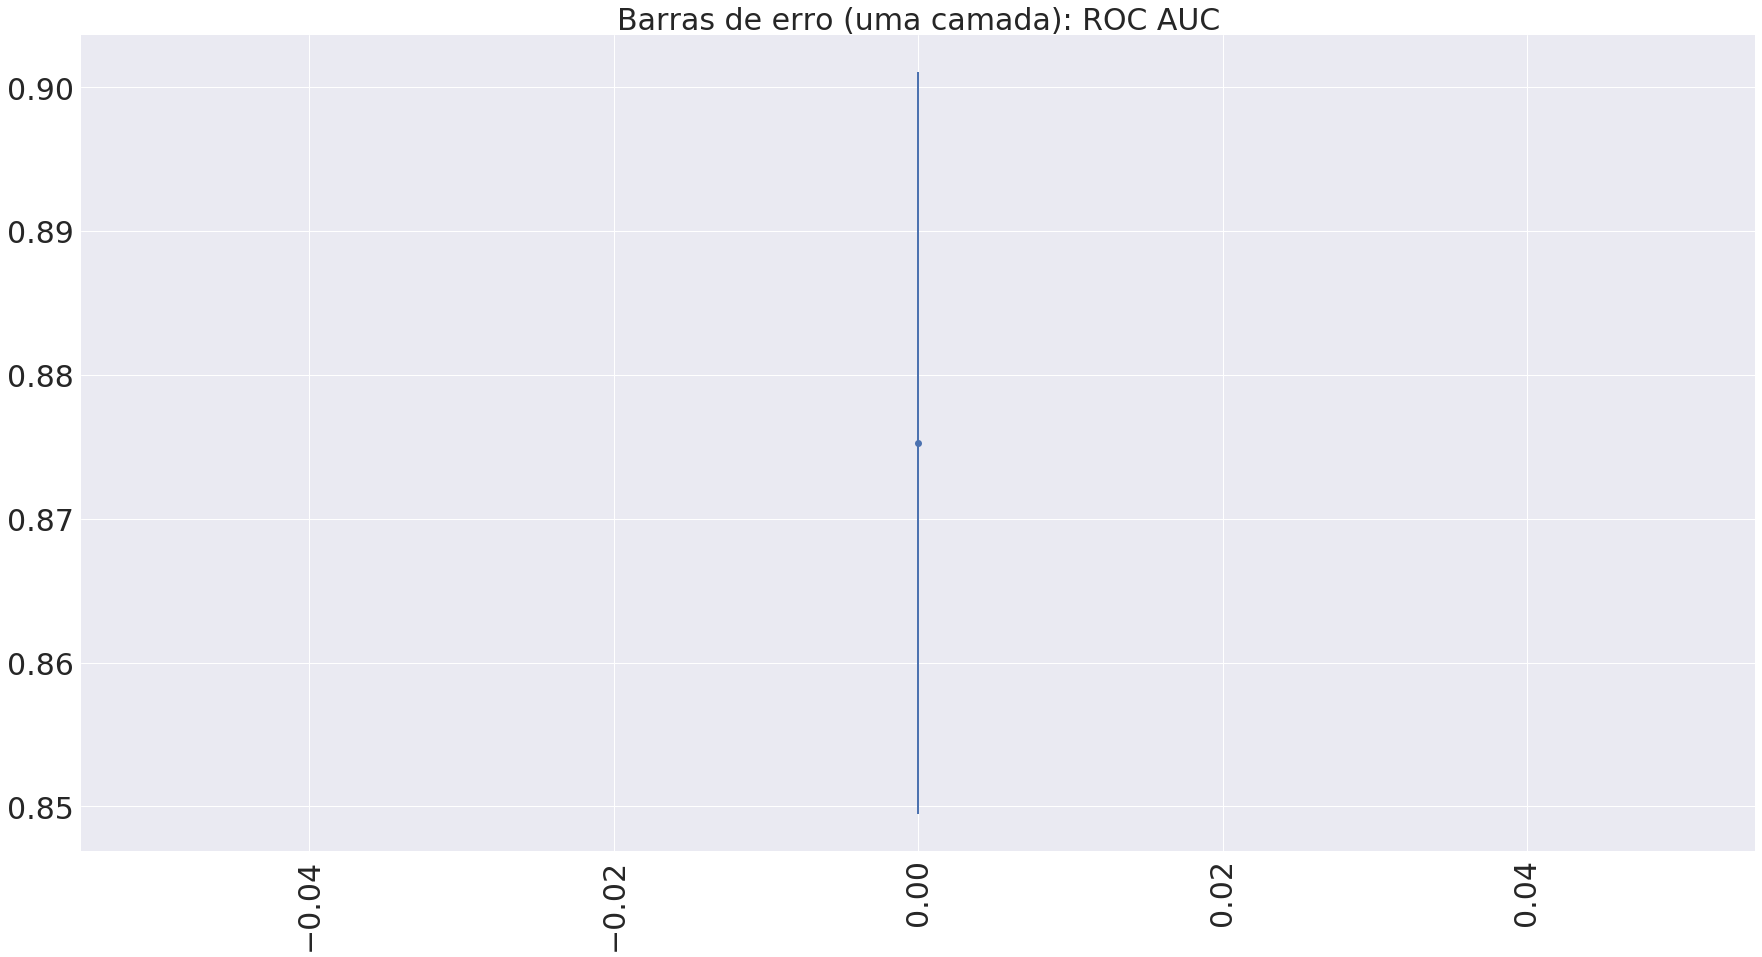

In [19]:
path_arquivos = 'Classificadores/Redes-neurais-MLP/'

clf_one_desbalanceado = joblib.load(path_arquivos+'mlp-one-abordagem-1-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl')

results = pd.DataFrame(clf_one_desbalanceado.cv_results_)
results.sort_values(by=['param_alpha', 'param_hidden_layer_sizes'], axis=0, inplace=True)

# results['param_hidden_layer_sizes'].head()

results_test = results.loc[:, 'split0_test_accuracy':'split9_train_roc_auc']
results_train = results_test.filter(regex=(".*train.*"))
results_test.drop(columns=results_train.columns,inplace=True)

lista_metricas = [('accuracy', 'acurácias'), ('average_precision', 'PRC AUC'), ('f1', 'F1 score'), ('precision', 'precisões'), ('recall', 'recall'), ('roc_auc', 'ROC AUC')]

for metrica in lista_metricas:

    results_test_filtered = results_test.filter(regex='.*_test_'+str(metrica[0])).transpose()

    fig = plt.figure(figsize=(30,15))

    plt.errorbar(results_test_filtered.columns, results_test_filtered.mean(), yerr=results_test_filtered.std(), fmt='o', lw=2)
    plt.title('Barras de erro (uma camada): ' + metrica[1], fontsize=30)
    plt.xticks(fontsize=30, rotation=90)
    plt.yticks(fontsize=30)
    plt.show()

ValueError: x and y must have same first dimension, but have shapes (7,) and (1,)

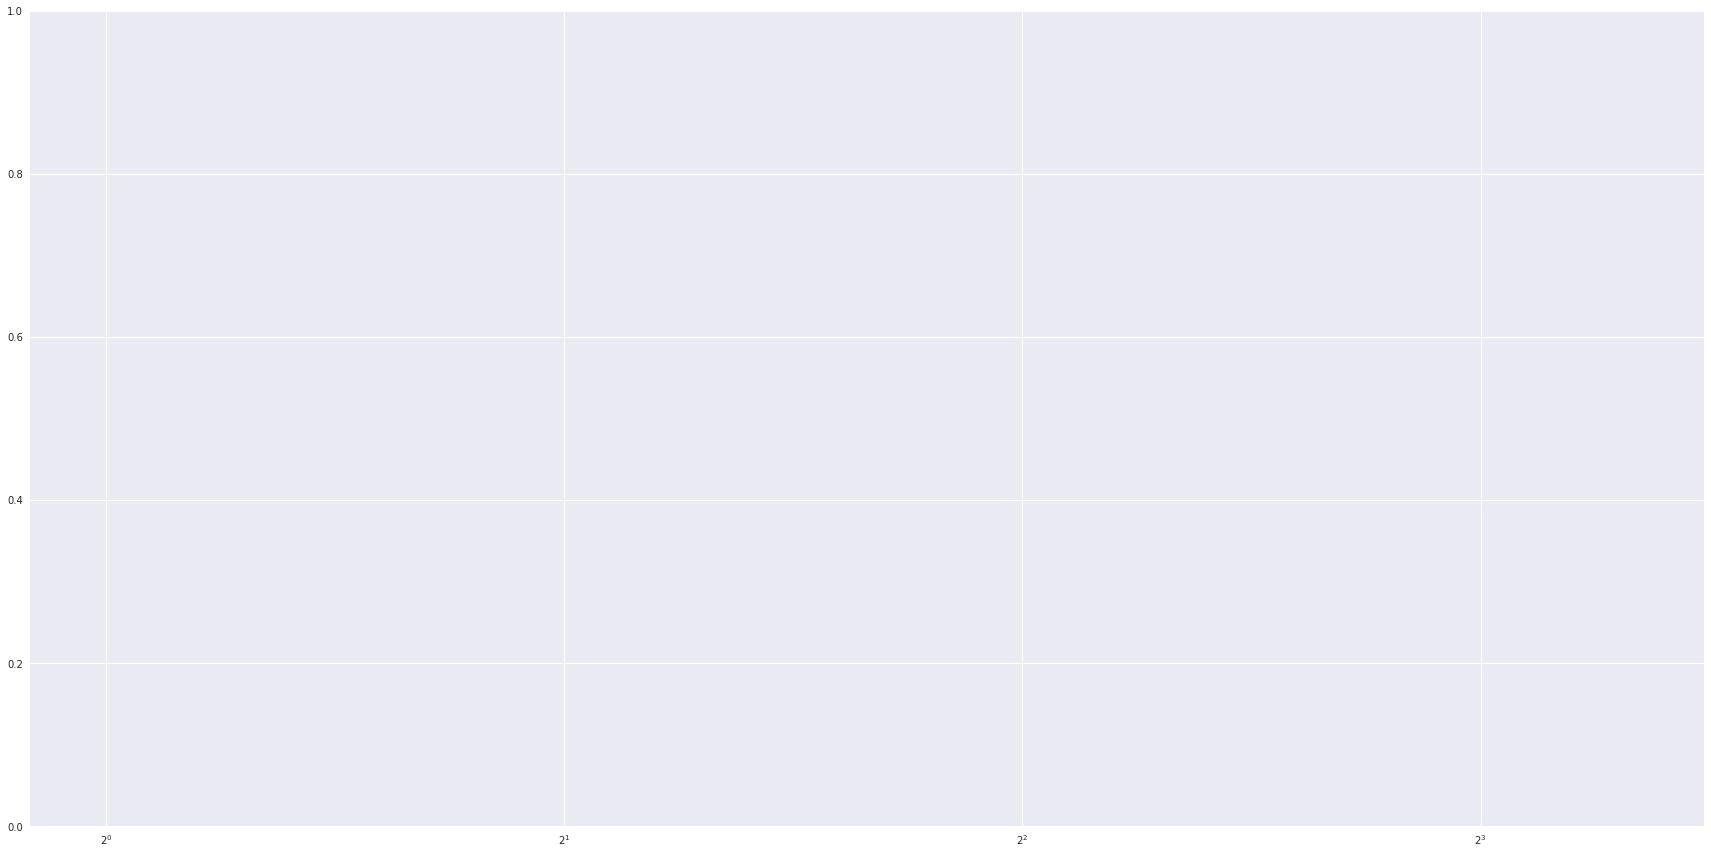

In [16]:
n_neurons = list(map(int,(np.logspace(start=1,stop=7,num=7,base=2))))
    
# display(results_train.head())    

for metrica in lista_metricas:

    results_test_filtered = results_test.filter(regex='.*_test_' + str(metrica[0])).transpose()
    results_train_filtered = results_train.filter(regex='.*_train_' + str(metrica[0])).transpose()
    
#     display(results_train_filtered.head(10))

#         results_test_filtered = results_test_filtered.iloc[:, 0:int((results_test_filtered.shape[1]/2))]
#         results_train_filtered = results_train_filtered.iloc[:, 0:int((results_train_filtered.shape[1]/2))]

#     display(results_train_filtered.head())

    results_test_filtered = results_test_filtered.iloc[:, 0:7]
    results_train_filtered = results_train_filtered.iloc[:, 0:7]
    
    
    fig = plt.figure(figsize=(30,15))
    plt.semilogx(n_neurons, results_test_filtered.mean(), label='Validação', color='green', lw=2, basex=2)
    plt.fill_between(n_neurons, results_test_filtered.mean() - results_test_filtered.std(),
                     results_test_filtered.mean() + results_test_filtered.std(), alpha=0.2, color='green', lw=2)

    plt.semilogx(n_neurons, results_train_filtered.mean(), label='Treino', color='blue', lw=2, basex=2)
    plt.fill_between(n_neurons, results_train_filtered.mean() - results_train_filtered.std(),
                     results_train_filtered.mean() + results_train_filtered.std(), alpha=0.2, color='blue', lw=2)
    plt.title('Curvas de validação: '+ metrica[1], fontsize=30)
    plt.xticks(fontsize=30, rotation=90)
    plt.xlabel('Número de neurônios', fontsize=30)
    plt.yticks(fontsize=30)
    plt.legend(loc='best', fontsize=30)
    plt.show()

In [8]:
# Descomentar somente se for necessário retreinar o classificador

# Abordagem 2: Imputar os valores faltantes e manter outliers

path_arquivos = 'Classificadores/Redes-neurais-MLP/' # Path para salvar os resultados dos classificadores

# clf_one.fit(pd.get_dummies(train_data_2), train_target_2) # Classes desbalanceadas
# joblib.dump(clf_one, 
#             path_arquivos+'mlp-one-abordagem-2-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada

clf_one.fit(train_data_b_2, train_target_b_2) # Classes balanceadas
joblib.dump(clf_one, 
            path_arquivos+'mlp-one-abordagem-2-balanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada

# clf_two.fit(pd.get_dummies(train_data_2), train_target_2)
# joblib.dump(clf_two, 
#             path_arquivos+'mlp-two-abordagem-2-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada

# clf_two.fit(train_data_b_2, train_target_b_2)
# joblib.dump(clf_two, 
#             path_arquivos+'mlp-two-abordagem-2-balanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada


/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/neural

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/neural

['Classificadores/Redes-neurais-MLP/mlp-one-abordagem-2-desbalanceado-dataset-10pct.pkl']

In [ ]:
path_arquivos = 'Classificadores/Redes-neurais-MLP/'

clf_one_desbalanceado = joblib.load(path_arquivos+'mlp-one-abordagem-2-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl')

results = pd.DataFrame(clf_one_desbalanceado.cv_results_)
results.sort_values(by=['param_alpha', 'param_hidden_layer_sizes'], axis=0, inplace=True)

# results['param_hidden_layer_sizes'].head()

results_test = results.loc[:, 'split0_test_accuracy':'split9_train_roc_auc']
results_train = results_test.filter(regex=(".*train.*"))
results_test.drop(columns=results_train.columns,inplace=True)

lista_metricas = [('accuracy', 'acurácias'), ('average_precision', 'PRC AUC'), ('f1', 'F1 score'), ('precision', 'precisões'), ('recall', 'recall'), ('roc_auc', 'ROC AUC')]

for metrica in lista_metricas:

    results_test_filtered = results_test.filter(regex='.*_test_'+str(metrica[0])).transpose()

    fig = plt.figure(figsize=(30,15))

    plt.errorbar(results_test_filtered.columns, results_test_filtered.mean(), yerr=results_test_filtered.std(), fmt='o', lw=2)
    plt.title('Barras de erro (uma camada): ' + metrica[1], fontsize=30)
    plt.xticks(fontsize=30, rotation=90)
    plt.yticks(fontsize=30)
    plt.show()

In [9]:
# Descomentar somente se for necessário retreinar o classificador

# Abordagem 3: Imputar os valores faltantes e retirar outliers

path_arquivos = 'Classificadores/Redes-neurais-MLP/' # Path para salvar os resultados dos classificadores

# clf_one.fit(pd.get_dummies(train_data_3), train_target_3) # Classes desbalanceadas
# joblib.dump(clf_one, 
#             path_arquivos+'mlp-one-abordagem-3-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada

clf_one.fit(train_data_b_3, train_target_b_3) # Classes balanceadas
joblib.dump(clf_one, 
            path_arquivos+'mlp-one-abordagem-3-balanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada

# clf_two.fit(pd.get_dummies(train_data_3), train_target_3)
# joblib.dump(clf_two, 
#             path_arquivos+'mlp-two-abordagem-3-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada

# clf_two.fit(train_data_b_3, train_target_b_3)
# joblib.dump(clf_two, 
#             path_arquivos+'mlp-two-abordagem-3-balanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada


/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/neural

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/neural

['Classificadores/Redes-neurais-MLP/mlp-one-abordagem-3-desbalanceado-dataset-10pct.pkl']

In [ ]:
path_arquivos = 'Classificadores/Redes-neurais-MLP/'

clf_one_desbalanceado = joblib.load(path_arquivos+'mlp-one-abordagem-3-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl')

results = pd.DataFrame(clf_one_desbalanceado.cv_results_)
results.sort_values(by=['param_alpha', 'param_hidden_layer_sizes'], axis=0, inplace=True)

# results['param_hidden_layer_sizes'].head()

results_test = results.loc[:, 'split0_test_accuracy':'split9_train_roc_auc']
results_train = results_test.filter(regex=(".*train.*"))
results_test.drop(columns=results_train.columns,inplace=True)

lista_metricas = [('accuracy', 'acurácias'), ('average_precision', 'PRC AUC'), ('f1', 'F1 score'), ('precision', 'precisões'), ('recall', 'recall'), ('roc_auc', 'ROC AUC')]

for metrica in lista_metricas:

    results_test_filtered = results_test.filter(regex='.*_test_'+str(metrica[0])).transpose()

    fig = plt.figure(figsize=(30,15))

    plt.errorbar(results_test_filtered.columns, results_test_filtered.mean(), yerr=results_test_filtered.std(), fmt='o', lw=2)
    plt.title('Barras de erro (uma camada): ' + metrica[1], fontsize=30)
    plt.xticks(fontsize=30, rotation=90)
    plt.yticks(fontsize=30)
    plt.show()

In [10]:
# Descomentar somente se for necessário retreinar o classificador

# Abordagem 4: Retirar os valores faltantes e retirar outliers

path_arquivos = 'Classificadores/Redes-neurais-MLP/' # Path para salvar os resultados dos classificadores

# clf_one.fit(pd.get_dummies(train_data_4), train_target_4) # Classes desbalanceadas
# joblib.dump(clf_one, 
#             path_arquivos+'mlp-one-abordagem-4-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada

clf_one.fit(train_data_b_4, train_target_b_4) # Classes balanceadas
joblib.dump(clf_one, 
            path_arquivos+'mlp-one-abordagem-4-balanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada

# clf_two.fit(pd.get_dummies(train_data_4), train_target_4)
# joblib.dump(clf_two, 
#             path_arquivos+'mlp-two-abordagem-4-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada

# clf_two.fit(train_data_b_4, train_target_b_4)
# joblib.dump(clf_two, 
#             path_arquivos+'mlp-two-abordagem-4-balanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada


/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/neural

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/neural

['Classificadores/Redes-neurais-MLP/mlp-one-abordagem-4-desbalanceado-dataset-10pct.pkl']

In [ ]:
path_arquivos = 'Classificadores/Redes-neurais-MLP/'

clf_one_desbalanceado = joblib.load(path_arquivos+'mlp-one-abordagem-4-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl')

results = pd.DataFrame(clf_one_desbalanceado.cv_results_)
results.sort_values(by=['param_alpha', 'param_hidden_layer_sizes'], axis=0, inplace=True)

# results['param_hidden_layer_sizes'].head()

results_test = results.loc[:, 'split0_test_accuracy':'split9_train_roc_auc']
results_train = results_test.filter(regex=(".*train.*"))
results_test.drop(columns=results_train.columns,inplace=True)

lista_metricas = [('accuracy', 'acurácias'), ('average_precision', 'PRC AUC'), ('f1', 'F1 score'), ('precision', 'precisões'), ('recall', 'recall'), ('roc_auc', 'ROC AUC')]

for metrica in lista_metricas:

    results_test_filtered = results_test.filter(regex='.*_test_'+str(metrica[0])).transpose()

    fig = plt.figure(figsize=(30,15))

    plt.errorbar(results_test_filtered.columns, results_test_filtered.mean(), yerr=results_test_filtered.std(), fmt='o', lw=2)
    plt.title('Barras de erro (uma camada): ' + metrica[1], fontsize=30)
    plt.xticks(fontsize=30, rotation=90)
    plt.yticks(fontsize=30)
    plt.show()